In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report 
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit,StratifiedShuffleSplit
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
test = pd.read_csv('poker-hand-testing.data')
train = pd.read_csv('poker-hand-training-true.data')

Text(0.5,0,'Hands')

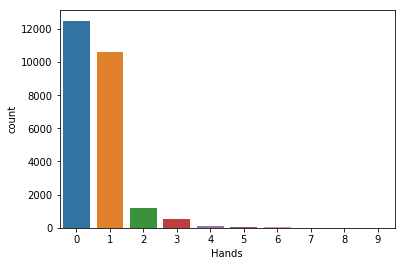

In [3]:
#From the count plot we can see that there is a really big class imbalance in the training data set.
#In order to deal with this, a stratifiedshuffle split will be used on our dataset to ensure that 
#at least some of the samples make it into both the training and validation sets.
sns.countplot('9',data=train)
plt.xlabel('Hands')

In [4]:
train['9'].value_counts()/len(train)

0    0.499540
1    0.423807
2    0.048223
3    0.020513
4    0.003719
5    0.002159
6    0.001439
7    0.000240
8    0.000200
9    0.000160
Name: 9, dtype: float64

In [5]:
y = train['9']
X = train.drop('9',axis=1)
folds = StratifiedShuffleSplit(n_splits=4, test_size=0.2)

In [6]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = lgb.LGBMClassifier(**params, n_estimators=20000, nthread=-1)

    test_pred_proba = np.zeros((train.shape[0], 10))
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
                verbose=False, early_stopping_rounds=200)

        y_pred_valid = model.predict_proba(X_valid)

        test_pred_proba[valid_idx] = y_pred_valid

    return accuracy_score(y_valid, y_pred_valid.argmax(1))

In [41]:
# params = {'colsample_bytree': (0.6, 0.8),
#       'learning_rate': (.0001, .5), 
#       'num_leaves': (2, 124), 
#       'subsample': (0.6, 1), 
#       'max_depth': (3, 120), 
#       'reg_alpha': (.001, 15.0), 
#       'reg_lambda': (.001, 15.0), 
#       'min_split_gain': (.001, .03),
#       'min_child_weight': (2, 80)}

# bo = BayesianOptimization(lgbm_evaluate, params)
# bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6975   |  0.6204   |  0.1779   |  6.896    |  35.32    |  0.02303  |  105.4    |  2.829    |  4.257    |  0.8238   |
|  2        |  0.6711   |  0.7557   |  0.2239   |  44.05    |  48.77    |  0.02682  |  52.48    |  6.73     |  12.15    |  0.9042   |
|  3        |  0.5982   |  0.7497   |  0.4036   |  75.3     |  41.49    |  0.02719  |  120.2    |  8.07     |  2.159    |  0.6475   |
|  4        |  0.623    |  0.6365   |  0.07714  |  15.0     |  2.687    |  0.004559 |  84.7     |  5.95     |  13.44    |  0.9068   |
|  5        |  0.5802   |  0.6616   |  0.3105   |  88.96    |  50.81    |  0.02558  |  38.62    |  15.0     |  3.572    |  0.6869   |
|  6        |  0.5686   |  0.8      |  0.5      |  3.0      | 

In [43]:
# params = bo.max['params']
# params['num_leaves'] = 4
# params['max_depth'] =5
# test_pred_proba = np.zeros((train.shape[0], 10))
# folds = StratifiedShuffleSplit(n_splits=4, test_size=0.2)
# for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, y)):
#         X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#         y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
#         model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
#         model.fit(X_train, y_train, 
#                 eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
#                 verbose=False, early_stopping_rounds=200)

#         y_pred_valid = model.predict_proba(X_valid)

#         test_pred_proba[valid_idx] = y_pred_valid

#         print(accuracy_score(y_valid, y_pred_valid.argmax(1)))

0.648140743702519
0.6345461815273891
0.6601359456217513
0.6405437824870052


In [46]:
# y = test['0']
# X = test.drop('0',axis=1)
# test_pred_proba = np.zeros((test.shape[0], 10))
# y_pred_valid = model.predict_proba(X)
# #test_pred_proba[valid_idx] = y_pred_valid
# print(accuracy_score(y, y_pred_valid.argmax(1)))

0.6446806446806447


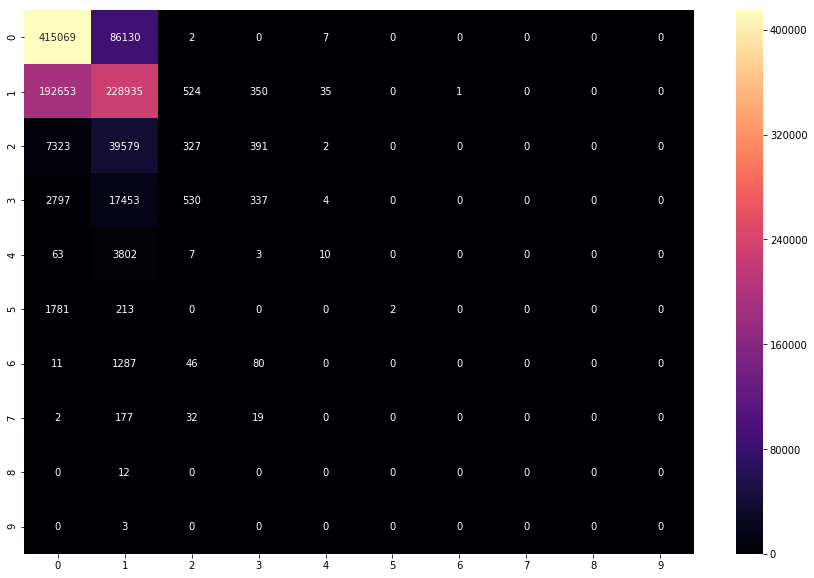

In [64]:
# cm = confusion_matrix(y,y_pred_valid.argmax(1))
# df_cm = pd.DataFrame(cm)
# plt.figure(figsize = (15,10))
# sns.heatmap(df_cm, annot=True, cmap = 'magma', fmt='g')

In [65]:
# After Bayesian Optimization, the this lightGBM model could only predict ~65.5% accuracy
#This could be because random forest struggles with fitting models that have 
#high class imbalances 

In [15]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

In [17]:
model = NeuralNet(10,16,10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [22]:
model

NeuralNet(
  (layer1): Linear(in_features=10, out_features=16, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=16, out_features=10, bias=True)
)

In [24]:
X_train = torch.tensor(X.values).long()
for epoch in range(50):
    # Forward Propagation
    y_pred = model(X_train)
    # Compute and print loss
    loss = criterion(y_pred, y)
    print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

RuntimeError: Expected object of scalar type Float but got scalar type Long for argument #4 'mat1'

In [29]:
X_train.size()

torch.Size([25009, 10])